# Building Kernels for Binary Data

Welcome back to my explorations in predicting the effects of cannabis strains based on their aromas. In short, different cannabis strains produce different suites of a particular class of molecules known as terpenes. Terpenes contribute to the smell and taste of cannabis, as well as *many* other plants (pine, lemon, lime, lavendar, mango, hops, etc...), and have attributable biological activities (e.g. pharmacological effects resulting from exposure to these terpenes at the appropriate dose). It is the endeavor of this collection of works to build classifiers that precisely predict whether a cannabis strain will produce a certain effect, given its olfactory profile. See my previous efforts [here](https://github.com/c-leber/Predicting-Cannabis-Effects-via-Smell/blob/main/Code_and_Report.ipynb).

The motivation for this particular notebook was the seeming lack of appropriate kernels for handling binary data. Across the data science blogosphere, kernel selection is often treated as just another hyperparameter that is tuned in the process of optimizing your model. Indeed, that is essentially how I treated kernel selection in my [prior work](https://github.com/c-leber/Predicting-Cannabis-Effects-via-Smell/blob/main/Code_and_Report.ipynb) building gaussian process classifiers for predicting 'Energetic' cannabis strains. In the same vein, during my PhD work, I often engaged with colleagues on selecting similarity metrics for unsupervised learning that are appropriate for one's data. In both the kernel case and the (very much related) similarity metric case, I have observed the tendecy of practitioners to choose kernels/metrics that they are most familiar with or that they often see in the literature. What is failed to be realized, in these cases, is that different kernels and metrics offer different conceptualizations of similarity between data points. In theory, we can harness these differences to inform our kernel/metric selection through careful consideration of our data, the problem we are trying to solve, and how data should be considered as similar or dissimilar in the context of the problem.

For example, I worked on a number of projects during my PhD that involved clustering metabolomics data (chemical compositional profiles) from cyanobacteria in order to identify chemogeographic patterns. In short, metabolomics (MS1) data can be presented as a multidimensional feature vector, with each dimension representing a different peak, and its numerical value representing the intensity or area of that peak in a chromatogram. We selected cosine distance as an appropriate metric for quantifying similarity/dissimilarity between samples because for this particular problem, it was important for similarity to be based not on the absolute value of peak intensities (which can vary for numerous reasons relating to sample preparation and instrument variations), but on their values in relation to each other. By using cosine distance, samples featuring the same peaks detected in similar proportion to each other were found to be less distant (more similar), even if their absolute peak intensities were very much different. If you are interested in learning more about some of my PhD work, please see [here](https://www.mdpi.com/1660-3397/18/10/515).

Ok, enough chatter, let's get started.

This time around, we are going to use Pyro to construct our gaussian process classifiers and build some new kernels, as it allows for more custmization, and is much less 'black box' than the sklearn implementation. Time to load-in...

In [14]:
!pip3 install pyro-ppl # I usually use conda, but the pyro version in conda is quite outdated

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
import skbio

import os
import torch

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from torch.distributions import constraints
from pyro.contrib.gp.kernels.kernel import Kernel
from pyro.nn.module import PyroParam

from imblearn.over_sampling import RandomOverSampler

pyro.enable_validation(True)
pyro.set_rng_seed(10)
pyro.__version__

'1.5.2'

As input data, we will use the same cannabis strains dataset from [kaggle]() as before, but will load-in our already cleaned version. We can also grab some code used previously to make our categorial input (feature) and output (target) data binary.

In [2]:
data = pd.read_csv('clean_data.csv')

In [3]:
def binarize_data(col_name, var_type):
    binarizer = MultiLabelBinarizer()
    bin_data = pd.DataFrame(binarizer.fit_transform(data[col_name].str.split(',')), columns=binarizer.classes_, index=data.index).add_prefix(var_type + '_')
    return bin_data

In [4]:
features = binarize_data('Flavor', 'feature')
targets = binarize_data('Effects', 'target')
targets = targets.drop(['target_DryMouth'], axis = 1)

features_0 = features.copy(deep=True)

We will focus again on predicting 'Energetic' cannabis strains as our target variable. Using first the radial basis function as our kernel (the default kernel in sklearn), let's learn a gaussian process classifier.

In [5]:
feats_train, feats_test, targets_train, targets_test = train_test_split(features, targets, test_size = 0.2, random_state = 10)
targets_train = targets_train['target_Energetic']
targets_test = targets_test['target_Energetic']

In [118]:
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim = 48, variance = torch.tensor(1.),
                        lengthscale = torch.tensor(1.))
likelihood = gp.likelihoods.Binary() # for classification
gpc = gp.models.VariationalGP(torch.Tensor(np.array(feats_train)), # variational supports the binary likelihood
                              torch.Tensor(np.array(targets_train)), 
                              kernel, 
                              likelihood = likelihood)

# set our lengthscale and variance priors from the log normal distribution, to keep them positive
gpc.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
gpc.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))

In [124]:
optimizer = torch.optim.Adam(gpc.parameters(), lr=0.006)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
losses = []
num_steps = 1000
for i in range(num_steps):
    print('step: ' + str(i))
    optimizer.zero_grad()
    loss = loss_fn(gpc.model, gpc.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 110


step: 831
step: 832
step: 833
step: 834
step: 835
step: 836
step: 837
step: 838
step: 839
step: 840
step: 841
step: 842
step: 843
step: 844
step: 845
step: 846
step: 847
step: 848
step: 849
step: 850
step: 851
step: 852
step: 853
step: 854
step: 855
step: 856
step: 857
step: 858
step: 859
step: 860
step: 861
step: 862
step: 863
step: 864
step: 865
step: 866
step: 867
step: 868
step: 869
step: 870
step: 871
step: 872
step: 873
step: 874
step: 875
step: 876
step: 877
step: 878
step: 879
step: 880
step: 881
step: 882
step: 883
step: 884
step: 885
step: 886
step: 887
step: 888
step: 889
step: 890
step: 891
step: 892
step: 893
step: 894
step: 895
step: 896
step: 897
step: 898
step: 899
step: 900
step: 901
step: 902
step: 903
step: 904
step: 905
step: 906
step: 907
step: 908
step: 909
step: 910
step: 911
step: 912
step: 913
step: 914
step: 915
step: 916
step: 917
step: 918
step: 919
step: 920
step: 921
step: 922
step: 923
step: 924
step: 925
step: 926
step: 927
step: 928
step: 929
step: 930


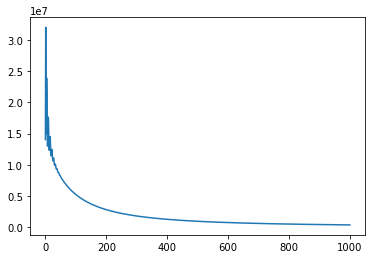

In [125]:
plt.plot(losses)

Loss curve looks good, a little bit of oscilation in the first 100 iterations, but smooth and descending after that. It seems our learning rate and number of iterations are reasonable. Let's see what values were learned for variance and lengthscale:

In [126]:
gpc.set_mode('guide')
print('variance: ' + str(round(gpc.kernel.variance.item(), 3)))
print('lengthscale: ' + str(round(gpc.kernel.lengthscale.item(), 3)))

variance: 0.98
lengthscale: 0.919


Now, we generate predictions from our test set, and output the precision of those predictions.

In [127]:
test  = torch.Tensor(np.array(feats_test))
test_target  = torch.Tensor(np.array(targets_test))

f_loc, f_var = gpc(test)
pred_target = gpc.likelihood(f_loc, f_var)
                     
test_target = list(np.array(test_target))
pred_target = list(np.array(pred_target))

In [128]:
accuracy = 100 * metrics.balanced_accuracy_score(test_target, pred_target)
precision = 100 * metrics.precision_score(test_target, pred_target, zero_division = 0)
fB = 100 * metrics.fbeta_score(test_target, pred_target, beta=0.5, zero_division = 0)

round(precision, 3)

28.311

Our null (baseline) model for predicting 'Energetic' cannabis strains has a precision of 28.77, so 28.311 is quite uninspiring. Now, as shown in our [previous efforts](https://github.com/c-leber/Predicting-Cannabis-Effects-via-Smell/blob/main/Code_and_Report.ipynb), we can indeed find GP models that make for better-than-baseline classifiers by balancing our classes with oversampling techniques and surveying various hyperparameter (including kernel type) sets. Here, we shall take an alternative approach, designing a kernel that should, in theory, provide a conceptualization of similarity that is customized to the problem that we are trying to solve. We hypothesize that applying a more appropriate kernel will result in a more precise classifier.

#### Understanding the radial basis kernel (and why it is perhaps not the best kernel for this job)
Recall that our feature space consists of 0s and 1s across 48 dimensions, with a maximum of 3 1's (3 associated smells/flavors) per sample. This means that there is a quite limited and discrete set of values by which our samples can covary. Let's calculate that set of covariance values using a dummy dataset with 6 dimensions.

In [304]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim = 6, variance = torch.tensor(1.),
                        lengthscale = torch.tensor(1.))

Xs = [[1,1,1,0,0,0], # samples can have 3, 2, or 1 attributed flavors, indicated as 1's
      [1,1,0,0,0,0],
      [1,0,0,0,0,0]]

Zs = [[1,1,1,0,0,0], # compared samples can have the same three flavors...
     [1,1,0,0,0,0],  # same two...
     [1,0,0,0,0,0],  # or same one
      
     [0,0,0,1,1,1],  # 3 different,
     [0,0,0,1,1,0],  # 2 different, or
     [0,0,0,1,0,0],  # 1 different
      
     [1,1,0,1,0,0],  # 2 same, 1 different;
     [1,0,0,1,1,0],  # 1 same, 2 different; 
     [1,0,0,1,0,0]]  # or 1 same and 1 different

# And that is it!

cov = []
num_1 = []
num_shared = []

for X in Xs:
    for Z in Zs:
        cov.append(kernel(torch.Tensor(np.array([X,Z])))[1, 0].item())
        num_1.append(sum(np.array(X) + np.array(Z)))
        num_shared.append(sum(np.array(X) * np.array(Z))*2)
        
rbf_covars_6 = pd.DataFrame([cov, num_1, num_shared])
rbf_covars_6 = rbf_covars_6.T
rbf_covars_6.columns = ['RBF', 'total_features', 'features_shared']
rbf_covars_6['total_features_1'] = rbf_covars_6['total_features'] + 1
rbf_covars_6['features_shared_1'] = rbf_covars_6['features_shared'] + 1
rbf_covars_6['proportion_of_features_shared'] = rbf_covars_6['features_shared']/rbf_covars_6['total_features']
rbf_covars_6['proportion_of_features_shared_+1'] = rbf_covars_6['features_shared_1']/rbf_covars_6['total_features_1']


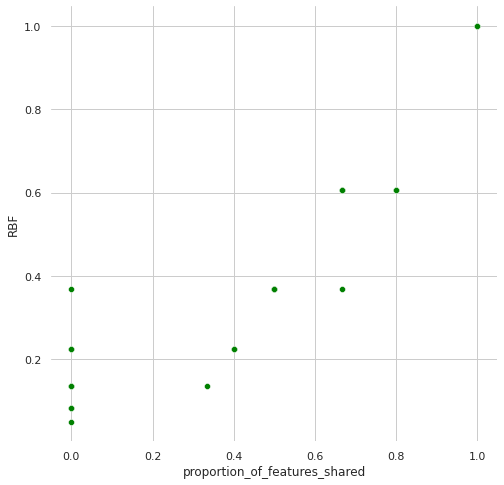

In [305]:
f, ax = plt.subplots(figsize=(8, 8))
sns.set_theme(style = "whitegrid")
sns.despine(f, left = True, bottom = True)

sns.scatterplot(x = "proportion_of_features_shared", y = "RBF",
                color = 'green', data = rbf_covars_6, ax = ax)

Here, we have plotted on the y axis the covariance between each pair of X and Z dummy data points, against the proportion of shared features on the x axis. The proportion of shared features is calculated as the total number of 1's that two samples have in the same dimensions divided by the total number of ones present in the two samples. One can immediately spot several issues.

We can see that the covariance attributed to pairs of samples with no features in common varies. This, in and of itself is not problematic. What *is* problematic is that some of the pairs of samples with no features in common are calculated via the radial basis function kernel to have higher covariance than some pairs of samples which do share features. This is because the radial basis function is not treating our 0's and 1's as binary indicators of whether a strain has a particular smell attribute, but instead treating them as numbers from a continuous array of possible values. Therefore, when two samples have 0's in the same dimensions, these contribute towards increased covariance for that pair (indirectly, by not increasing the distance between the two samples). Features are valued the same if two samples both have 0's or both have 1's. For our dataset (and many other datasets with binary varaibles as the feature space), this is not appropriate. 

Another visible issue is that there are pairs of samples that share smaller proportions of features but have the same covariance as pairs of samples that share larger proportions of features. If our expectation is that strains with more smells in common are more likely to have the same effects, this presents a problem.

Briefly, let's take a look at how our covariance structure varies, with changes to lengthscale and variance.


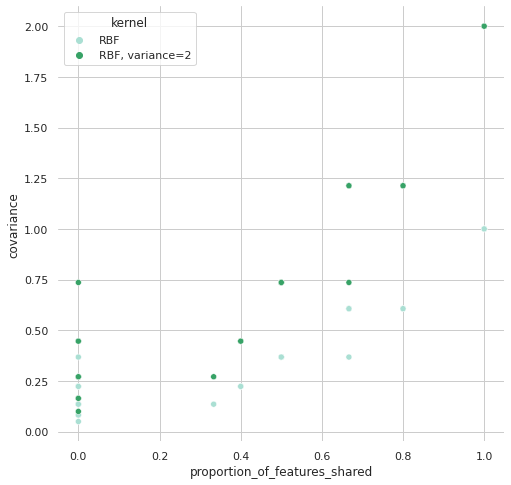

In [306]:
pyro.clear_param_store()
# same kernel, except variance is doubled
kernel = gp.kernels.RBF(input_dim = 6, variance = torch.tensor(2.),
                        lengthscale = torch.tensor(1.))

cov = []
num_1 = []
num_shared = []

for X in Xs:
    for Z in Zs:
        cov.append(kernel(torch.Tensor(np.array([X,Z])))[1, 0].item())
        
rbf_covars_6['RBF, variance=2'] = cov

f, ax = plt.subplots(figsize = (8, 8))
sns.set_theme(style = "whitegrid")
sns.despine(f, left = True, bottom = True)

sns.scatterplot(x = "proportion_of_features_shared", y = "covariance",
                hue = "kernel", 
                palette = 'BuGn',
                data = pd.melt(rbf_covars_6, id_vars = ["proportion_of_features_shared"], 
                             var_name = 'kernel', 
                               value_name = 'covariance').query("kernel == 'RBF' or kernel == 'RBF, variance=2'"), ax = ax)


Doubling our variance simply doubles our covariance values, stretching them from a range of 0 to 1, to now 0 to 2.

Modifying lengthscale is a bit more interesting.

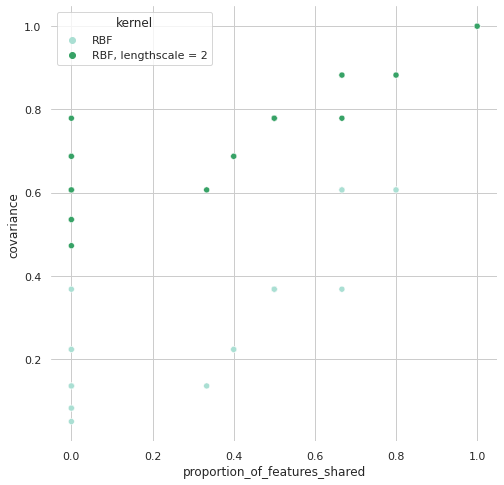

In [307]:
pyro.clear_param_store()
# same as original kernel, except lengthscale is doubled
kernel = gp.kernels.RBF(input_dim = 6, variance = torch.tensor(1.),
                        lengthscale = torch.tensor(2.))

cov = []
num_1 = []
num_shared = []

for X in Xs:
    for Z in Zs:
        cov.append(kernel(torch.Tensor(np.array([X,Z])))[1, 0].item())
        
rbf_covars_6['RBF, lengthscale = 2'] = cov

f, ax = plt.subplots(figsize = (8, 8))
sns.set_theme(style = "whitegrid")
sns.despine(f, left = True, bottom = True)

sns.scatterplot(x = "proportion_of_features_shared", y = "covariance",
                hue = "kernel", 
                palette = 'BuGn',
                data = pd.melt(rbf_covars_6, id_vars = ["proportion_of_features_shared"], 
                             var_name = 'kernel', 
                               value_name = 'covariance').query("kernel == 'RBF' or kernel == 'RBF, lengthscale = 2'"), ax = ax)


In doubling the lengthscale, we have essentially halved the distance between each pair of points. This results in a compression of our covariance value range towards one, increasing all covariance values towards one in the process. And now, if we half it?...

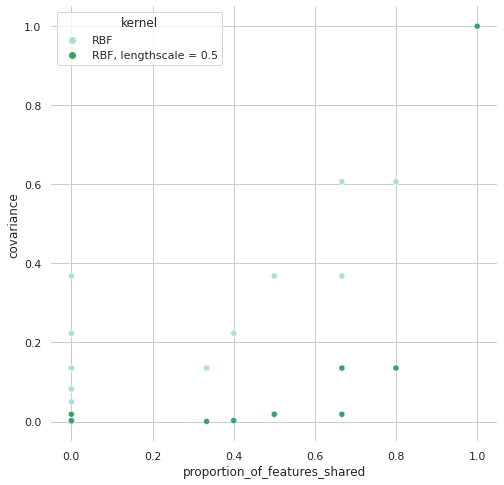

In [308]:
pyro.clear_param_store()
# same as original kernel, except lengthscale is doubled
kernel = gp.kernels.RBF(input_dim = 6, variance = torch.tensor(1.),
                        lengthscale = torch.tensor(0.5))

cov = []
num_1 = []
num_shared = []

for X in Xs:
    for Z in Zs:
        cov.append(kernel(torch.Tensor(np.array([X,Z])))[1, 0].item())
        
rbf_covars_6['RBF, lengthscale = 0.5'] = cov

f, ax = plt.subplots(figsize = (8, 8))
sns.set_theme(style = "whitegrid")
sns.despine(f, left = True, bottom = True)

sns.scatterplot(x = "proportion_of_features_shared", y = "covariance",
                hue = "kernel", 
                palette = 'BuGn',
                data = pd.melt(rbf_covars_6, id_vars = ["proportion_of_features_shared"], 
                             var_name = 'kernel', 
                               value_name = 'covariance').query("kernel == 'RBF' or kernel == 'RBF, lengthscale = 0.5'"), ax = ax)


... we double the distance between each point, and so compress our covariance values towards 0. 

Regardless of how we vary variance and length scale, we do not fundamentally change how this kernel conceptualizes covariance (similarity), we merely scale it. Therefore, a kernel with a better conceptualization of covariance regarding our specific problem and our specific data is required.

#### Designing a kernel for binary data

In playing with our dummy data above, we used proportion of shared features as a measuring stick for judging how the radial basis function conceptualized similarity between our samples. We used this because it represents a very intutive way of defining which of our samples are more or less similar to each other. And, it may very well make for a good kernel!

For clarity on our approach, if we have two samples:

(1,1,1,0,0,0) and (0,0,1,1,1,0), the proportion of shared features is:

2 (for the 1's in each sample in the third dimension) / 6 (three 1's per sample) = 0.333

One improvement we could think to make is how this potential covariance metric treats sample pairs that have no features in common - currently it treats them all the same, generating covariance value of 0. But in the context of our dataset, it would perhaps make more sense to consider samples each with three different features (total of three features each) *less* similar than samples each with one different feature (total of one feature each) because we effectively know more about the samples with three different features, and so are more certain of their difference.

We can easily make this improvement by adding a constant (1, for example) to the numerator and denominator of our proportion of shared features. It should be noted that adding this (positive) constant will cause this covariance metric to no longer include 0 as its lower bound, resulting in a covariance matrix that is positive definite, rather than positive semi-deinite.

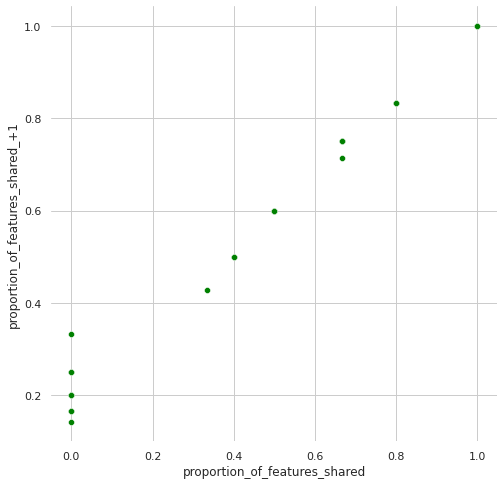

In [310]:
f, ax = plt.subplots(figsize = (8, 8))
sns.set_theme(style = "whitegrid")
sns.despine(f, left = True, bottom = True)

sns.scatterplot(x = "proportion_of_features_shared", y = "proportion_of_features_shared_+1",
                color = 'green',
                data = rbf_covars_6, 
                ax = ax)


As can be seen above, adding one to our numerator and denominator of proportion of shared features (shown on the y axis) allows us to tease apart a few more points.

Now, one has probably noticed that our covariance metric does not yet have any parameters, preventing it from being a learnable kernel. There are an unlimited number of ways that we could think to add parameters that would allow for a broader functional space to be explored while learning our gaussian process classifier. At the same time, with too many parameters to try to learn, our model may struggle to optimize. Therefore, we must be judicious in what parameters we select to implement.

I was quite intrigued by an approach reported [here](https://upcommons.upc.edu/bitstream/handle/2099.1/24508/99930.pdf?sequence=1), where binary features were weighted by what the author termed as an inverting function of the marginal probabilities of each feature. This inverting function has a parameter alpha that can take any value > 0, and takes this form:

h(z) = (1 − z^α)^(1/α)

Weighting by inverted marginal probabilities for each binary variable will cause more common features to be less impactful on increasing covariance when they are shared, while will cause shared rare features to strongly increase covariance. Our alphas parameter modulates the magnitude of this differential influence between rare and common features. A value of 1 for alpha will maintain the marginal probabilities for each binary variable. Values > 1 will push all marginal probabilities towards 1, lessening the differential.

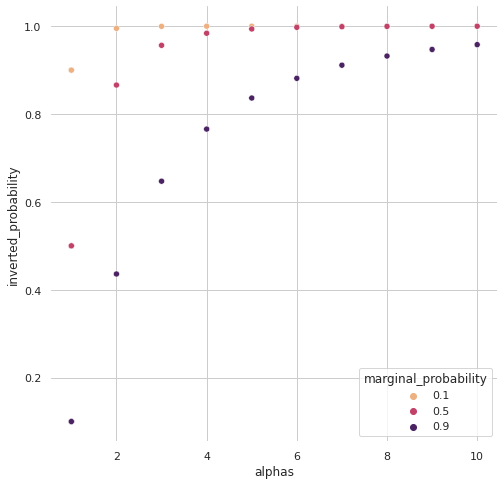

In [324]:
alphas = []
probs = []
inverts = [] 
for a in range(1,11):
    for p in [0.1, 0.5, 0.9]:
        alphas.append(a)
        probs.append(p)
        inverts.append((1-(p**a))**(1/a))
    for p in [0.1, 0.5, 0.9]:
        af = a/10
        alphas.append(af)
        probs.append(p)
        inverts.append((1-(p**af))**(1/af))
        
alpha_df = pd.DataFrame([alphas, probs, inverts]).T
alpha_df.columns = ['alphas', 'marginal_probability', 'inverted_probability']

f, ax = plt.subplots(figsize = (8, 8))
sns.set_theme(style = 'whitegrid')
sns.despine(f, left = True, bottom = True)

sns.scatterplot(x = 'alphas', y = 'inverted_probability',
                hue = 'marginal_probability',
                palette = sns.color_palette('flare', as_cmap = True),
                data = alpha_df.query('alphas >= 1'), 
                ax = ax)        
    

Values < 1 push all marginal probabilities to approach 0.

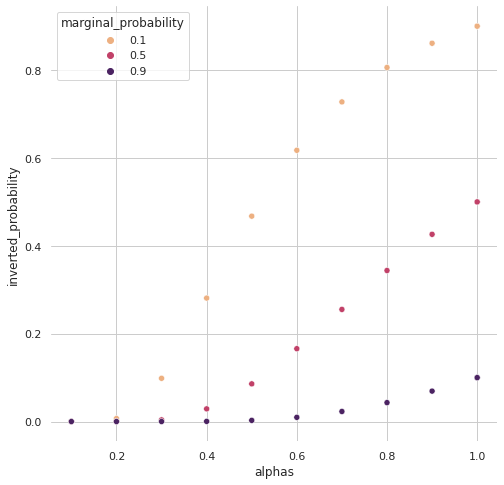

In [325]:
f, ax = plt.subplots(figsize = (8, 8))
sns.set_theme(style = 'whitegrid')
sns.despine(f, left = True, bottom = True)

sns.scatterplot(x = 'alphas', y = 'inverted_probability',
                hue = 'marginal_probability',
                palette = sns.color_palette('flare', as_cmap = True),
                data = alpha_df.query('alphas <= 1'), 
                ax = ax)        
    

Our first kernel, will include the alpha parameter, as well as a variance parameter. We will refer to the kernel as 'Kernel alpha', or KA for short. 

KA = ((number of shared features * Pa) + 0.25 / (total number of features * Pa) + 0.25) * variance

where Pa is the vector of alpha inverted marginal probabilities of the features.

We build a class for our kernel below, translating the above pseudoequation into matrix operations.

Instead of adding 1 to the top and bottom of our proportion of shared features as discussed above, we add (0.5)^2 or 0.25, the thought being that 0.5 would represent a 'middle of the road' marginal feature probability.


In [6]:
class KA(Kernel):

    def __init__(self, input_dim, variance = None, alpha = None, marginal_probs = None, active_dims = None):
        super().__init__(input_dim, active_dims)

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)

        alpha = torch.tensor(1.) if alpha is None else alpha
        self.alpha = PyroParam(alpha, constraints.positive)
        
        self.marginal_probs = marginal_probs

    def _funct(self, X, Z = None):
        if Z is None:
            Z = X
        X = self._slice_input(X)
        Z = self._slice_input(Z)
        if X.size(1) != Z.size(1):
            raise ValueError("Inputs must have the same number of features.")
        
        P = self.marginal_probs
        Pa = (1 - (P**self.alpha))**(1/self.alpha)
        XPa = X * Pa
        ZPa = Z * Pa
        X2 = (XPa ** 2).sum(1, keepdim=True)
        Z2 = (ZPa ** 2).sum(1, keepdim=True)
        XZ = XPa.matmul(ZPa.t())
        K = ((2 * XZ) + 0.25) / ((torch.zeros(XZ.size())+X2+Z2.t()) + 0.25)
        return K

    def _diag(self, X):
        
        return self.variance.expand(X.size(0))

    def forward(self, X, Z = None, diag = False):
        if diag:
            return self._diag(X)

        K = self._funct(X, Z)
        return self.variance * K

Almost time to try it out! But before we do, we need the marginal probabilities for each feature. We will generate these by adapting some code from our previous efforts with this dataset, and taking a bootstrap approach pulling 1000 random samples from our dataset 100 times.

In [7]:
#generate vector of marginal probabilities via bootstrapping

marginal_probs = pd.DataFrame()
 
for i in range(100):
    print('iteration: ' + str(i))
    features_bootstrap = features.sample(n=1000, replace=True, random_state=i)
    event_marg = []
    for f in features_bootstrap.columns:
        event_m = len(features_bootstrap[(features_bootstrap[f] == 1)])/len(features_bootstrap)
        event_marg.append(event_m)
            
    marginal_probs[str(i)] = event_marg 

marginal_probs = marginal_probs.T.mean()

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

In [8]:
marg_probs_df = pd.DataFrame(features.sum()/len(features))
marg_probs_df.columns = ['full_sampleset']
marg_probs_df['bootstrapX100'] = list(marginal_probs)
marg_probs_df

,full_sampleset,bootstrapX100
feature_Ammonia,0.013508,0.01421
feature_Apple,0.006972,0.00750
feature_Apricot,0.003922,0.00405
feature_Berry,0.159041,0.15848
feature_BlueCheese,0.003922,0.00388
feature_Blueberry,0.064052,0.06348
feature_Bubblegum,0.000436,0.00055
feature_Butter,0.008715,0.00858
feature_Cheese,0.026580,0.02761
feature_Chemical,0.017865,0.01778


In [9]:
marginal_probs = marg_probs_df['bootstrapX100']

In [874]:
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.clear_param_store()
kernel = KA(input_dim = 48, 
            variance = torch.tensor(1.),
            alpha = torch.tensor(1.),
           marginal_probs = torch.tensor(np.array(marginal_probs)))
likelihood = gp.likelihoods.Binary()
gpc = gp.models.VariationalGP(torch.Tensor(np.array(feats_train)), 
                              torch.Tensor(np.array(targets_train)), 
                              kernel, 
                              likelihood = likelihood)

# sample our alpha and variance from the log normal distribution, to keep them positive
gpc.kernel.alpha = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0)) # set prior
gpc.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0)) # set prior


In [875]:
optimizer = torch.optim.Adam(gpc.parameters(), lr=0.02)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
losses = []
num_steps = 1000
for i in range(num_steps):
    print('step: ' + str(i))
    optimizer.zero_grad()
    loss = loss_fn(gpc.model, gpc.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 110


step: 831
step: 832
step: 833
step: 834
step: 835
step: 836
step: 837
step: 838
step: 839
step: 840
step: 841
step: 842
step: 843
step: 844
step: 845
step: 846
step: 847
step: 848
step: 849
step: 850
step: 851
step: 852
step: 853
step: 854
step: 855
step: 856
step: 857
step: 858
step: 859
step: 860
step: 861
step: 862
step: 863
step: 864
step: 865
step: 866
step: 867
step: 868
step: 869
step: 870
step: 871
step: 872
step: 873
step: 874
step: 875
step: 876
step: 877
step: 878
step: 879
step: 880
step: 881
step: 882
step: 883
step: 884
step: 885
step: 886
step: 887
step: 888
step: 889
step: 890
step: 891
step: 892
step: 893
step: 894
step: 895
step: 896
step: 897
step: 898
step: 899
step: 900
step: 901
step: 902
step: 903
step: 904
step: 905
step: 906
step: 907
step: 908
step: 909
step: 910
step: 911
step: 912
step: 913
step: 914
step: 915
step: 916
step: 917
step: 918
step: 919
step: 920
step: 921
step: 922
step: 923
step: 924
step: 925
step: 926
step: 927
step: 928
step: 929
step: 930


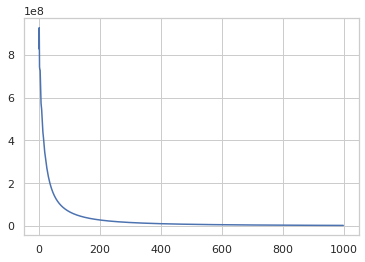

In [876]:
plt.plot(losses)

In [877]:
gpc.set_mode('guide')
print('variance: ' + str(round(gpc.kernel.variance.item(),3)))
print('alpha: ' + str(round(gpc.kernel.alpha.item(),3)))

variance: 20.27
alpha: 0.533


In [878]:
test  = torch.Tensor(np.array(feats_test))
test_target  = torch.Tensor(np.array(targets_test))

f_loc, f_var = gpc(test)
pred_target = gpc.likelihood(f_loc, f_var)
                     
test_target = list(np.array(test_target))
pred_target = list(np.array(pred_target))

In [879]:
accuracy = 100 * metrics.balanced_accuracy_score(test_target, pred_target)
precision = 100 * metrics.precision_score(test_target, pred_target, zero_division = 0)
fB = 100 * metrics.fbeta_score(test_target, pred_target, beta = 0.5, zero_division = 0)

round(precision, 3)

27.386

More appropriate kernel; same general level of precision. Not our hoped for outcome by any means, but we must carry on!

Perhaps additional parameterization of our kernel will allow for more flexibility in the function space, and so contribute to improved precision. At the very least, I have a couple more parameterization ideas to explore.

Repeated experiments with the above model tended to yield large (e.g. > 5) learned variance values. This could be interpretted in a number of ways. It could indicate that the covariance values between our sample pairs tend to be very small, in which case the variance parameter is the ideal solution for increasing those covariance values for improved gradients.

Another possibility is that pairs of samples with one or none features in common are being penalized *too harshly*. We can address this potential issue by incorporating a beta parameter that modulates the magnitude of the +1 component that is added to the numerator and denominator of our proportion of shared features. We will want to assure that beta is > 0, so we will assign it priors from the log normal distribution and impose a positive constraint.

It may also be true that there is *not enough* differentiation between sample pairs that share multiple features and those that do not. We can play with how much weight is given to mismatched features by adding another term to our denominator that represents the total number of features present in one sample but not the other, per pair. We will multiply this term by the parameter gamma, which we will also assign it priors from the log normal distribution and impose a positive constraint. In this way, we can shrink or expand the denominator of our proportion of shared features as a function of the mismatched features in each sample pair.

This further parameterized kernel is implemented below.

In [10]:
class KABG(Kernel):

    def __init__(self, input_dim, variance = None, alpha = None, beta = None, gamma= None, marginal_probs = None, active_dims = None):
        super().__init__(input_dim, active_dims)

        variance = torch.tensor(1.) if variance is None else variance
        self.variance = PyroParam(variance, constraints.positive)

        alpha = torch.tensor(1.) if alpha is None else alpha
        self.alpha = PyroParam(alpha, constraints.positive)
        
        beta = torch.tensor(1.) if beta is None else beta
        self.beta = PyroParam(beta, constraints.positive)
        
        gamma = torch.tensor(1.) if gamma is None else gamma
        self.gamma = PyroParam(gamma, constraints.positive)
        
        self.marginal_probs = marginal_probs

    def _funct(self, X, Z = None):
        if Z is None:
            Z = X
        X = self._slice_input(X)
        Z = self._slice_input(Z)
        if X.size(1) != Z.size(1):
            raise ValueError("Inputs must have the same number of features.")
        
        P = self.marginal_probs
        Pa = (1 - (P**self.alpha))**(1/self.alpha)
        XPa = X * Pa
        ZPa = Z * Pa
        X2 = (XPa ** 2).sum(1, keepdim=True)
        Z2 = (ZPa ** 2).sum(1, keepdim=True)
        XZ = XPa.matmul(ZPa.t())
        numerator = ((2 * XZ) + self.beta)
        all_feats = (torch.zeros(XZ.size())+X2+Z2.t())
        shared_feats = (2 * XZ)
        denominator = (shared_feats + ((all_feats - shared_feats) * self.gamma) + self.beta)
        K = numerator / denominator
        return K

    def _diag(self, X):
        
        return self.variance.expand(X.size(0))

    def forward(self, X, Z=None, diag=False):
        if diag:
            return self._diag(X)

        K = self._funct(X, Z)
        return self.variance * K

Let's try out this further parameterized kernel, and see if we have any better luck.

In [933]:
torch.set_default_tensor_type(torch.DoubleTensor)
pyro.clear_param_store()
kernel = KABG(input_dim = 48, 
              variance = torch.tensor(1.),
              alpha = torch.tensor(1.),
              beta = torch.tensor(1.),
              gamma = torch.tensor(1.),
              marginal_probs = torch.tensor(np.array(marginal_probs)))
likelihood = gp.likelihoods.Binary()
gpc = gp.models.VariationalGP(torch.Tensor(np.array(feats_train)), 
                              torch.Tensor(np.array(targets_train)), 
                              kernel,
                              likelihood = likelihood,
                             jitter = 0.0001)

# sample our alpha and variance from the log normal distribution, to keep them positive
gpc.kernel.alpha = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0)) # set prior
gpc.kernel.beta = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0)) # set prior
gpc.kernel.gamma = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0)) # set prior
gpc.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0)) # set prior


In [934]:
optimizer = torch.optim.Adam(gpc.parameters(), lr=0.001)
loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
losses = []
num_steps = 3000
for i in range(num_steps):
    print('step: ' + str(i))
    optimizer.zero_grad()
    loss = loss_fn(gpc.model, gpc.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

step: 0
step: 1
step: 2
step: 3
step: 4
step: 5
step: 6
step: 7
step: 8
step: 9
step: 10
step: 11
step: 12
step: 13
step: 14
step: 15
step: 16
step: 17
step: 18
step: 19
step: 20
step: 21
step: 22
step: 23
step: 24
step: 25
step: 26
step: 27
step: 28
step: 29
step: 30
step: 31
step: 32
step: 33
step: 34
step: 35
step: 36
step: 37
step: 38
step: 39
step: 40
step: 41
step: 42
step: 43
step: 44
step: 45
step: 46
step: 47
step: 48
step: 49
step: 50
step: 51
step: 52
step: 53
step: 54
step: 55
step: 56
step: 57
step: 58
step: 59
step: 60
step: 61
step: 62
step: 63
step: 64
step: 65
step: 66
step: 67
step: 68
step: 69
step: 70
step: 71
step: 72
step: 73
step: 74
step: 75
step: 76
step: 77
step: 78
step: 79
step: 80
step: 81
step: 82
step: 83
step: 84
step: 85
step: 86
step: 87
step: 88
step: 89
step: 90
step: 91
step: 92
step: 93
step: 94
step: 95
step: 96
step: 97
step: 98
step: 99
step: 100
step: 101
step: 102
step: 103
step: 104
step: 105
step: 106
step: 107
step: 108
step: 109
step: 110


step: 831
step: 832
step: 833
step: 834
step: 835
step: 836
step: 837
step: 838
step: 839
step: 840
step: 841
step: 842
step: 843
step: 844
step: 845
step: 846
step: 847
step: 848
step: 849
step: 850
step: 851
step: 852
step: 853
step: 854
step: 855
step: 856
step: 857
step: 858
step: 859
step: 860
step: 861
step: 862
step: 863
step: 864
step: 865
step: 866
step: 867
step: 868
step: 869
step: 870
step: 871
step: 872
step: 873
step: 874
step: 875
step: 876
step: 877
step: 878
step: 879
step: 880
step: 881
step: 882
step: 883
step: 884
step: 885
step: 886
step: 887
step: 888
step: 889
step: 890
step: 891
step: 892
step: 893
step: 894
step: 895
step: 896
step: 897
step: 898
step: 899
step: 900
step: 901
step: 902
step: 903
step: 904
step: 905
step: 906
step: 907
step: 908
step: 909
step: 910
step: 911
step: 912
step: 913
step: 914
step: 915
step: 916
step: 917
step: 918
step: 919
step: 920
step: 921
step: 922
step: 923
step: 924
step: 925
step: 926
step: 927
step: 928
step: 929
step: 930


step: 1592
step: 1593
step: 1594
step: 1595
step: 1596
step: 1597
step: 1598
step: 1599
step: 1600
step: 1601
step: 1602
step: 1603
step: 1604
step: 1605
step: 1606
step: 1607
step: 1608
step: 1609
step: 1610
step: 1611
step: 1612
step: 1613
step: 1614
step: 1615
step: 1616
step: 1617
step: 1618
step: 1619
step: 1620
step: 1621
step: 1622
step: 1623
step: 1624
step: 1625
step: 1626
step: 1627
step: 1628
step: 1629
step: 1630
step: 1631
step: 1632
step: 1633
step: 1634
step: 1635
step: 1636
step: 1637
step: 1638
step: 1639
step: 1640
step: 1641
step: 1642
step: 1643
step: 1644
step: 1645
step: 1646
step: 1647
step: 1648
step: 1649
step: 1650
step: 1651
step: 1652
step: 1653
step: 1654
step: 1655
step: 1656
step: 1657
step: 1658
step: 1659
step: 1660
step: 1661
step: 1662
step: 1663
step: 1664
step: 1665
step: 1666
step: 1667
step: 1668
step: 1669
step: 1670
step: 1671
step: 1672
step: 1673
step: 1674
step: 1675
step: 1676
step: 1677
step: 1678
step: 1679
step: 1680
step: 1681
step: 1682

step: 2337
step: 2338
step: 2339
step: 2340
step: 2341
step: 2342
step: 2343
step: 2344
step: 2345
step: 2346
step: 2347
step: 2348
step: 2349
step: 2350
step: 2351
step: 2352
step: 2353
step: 2354
step: 2355
step: 2356
step: 2357
step: 2358
step: 2359
step: 2360
step: 2361
step: 2362
step: 2363
step: 2364
step: 2365
step: 2366
step: 2367
step: 2368
step: 2369
step: 2370
step: 2371
step: 2372
step: 2373
step: 2374
step: 2375
step: 2376
step: 2377
step: 2378
step: 2379
step: 2380
step: 2381
step: 2382
step: 2383
step: 2384
step: 2385
step: 2386
step: 2387
step: 2388
step: 2389
step: 2390
step: 2391
step: 2392
step: 2393
step: 2394
step: 2395
step: 2396
step: 2397
step: 2398
step: 2399
step: 2400
step: 2401
step: 2402
step: 2403
step: 2404
step: 2405
step: 2406
step: 2407
step: 2408
step: 2409
step: 2410
step: 2411
step: 2412
step: 2413
step: 2414
step: 2415
step: 2416
step: 2417
step: 2418
step: 2419
step: 2420
step: 2421
step: 2422
step: 2423
step: 2424
step: 2425
step: 2426
step: 2427

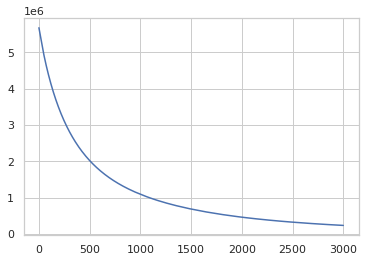

In [935]:
plt.plot(losses)

In [936]:
gpc.set_mode('guide')
print('variance: ' + str(round(gpc.kernel.variance.item(),3)))
print('alpha: ' + str(round(gpc.kernel.alpha.item(),3)))
print('beta: ' + str(round(gpc.kernel.beta.item(),3)))
print('gamma: ' + str(round(gpc.kernel.gamma.item(),3)))

variance: 0.876
alpha: 1.672
beta: 0.38
gamma: 2.308


In [937]:
test  = torch.Tensor(np.array(feats_test))
test_target  = torch.Tensor(np.array(targets_test))

f_loc, f_var = gpc(test)
pred_target = gpc.likelihood(f_loc, f_var)
                     
test_target = list(np.array(test_target))
pred_target = list(np.array(pred_target))

In [938]:
accuracy = 100 * metrics.balanced_accuracy_score(test_target, pred_target)
precision = 100 * metrics.precision_score(test_target, pred_target, zero_division = 0)
fB = 100 * metrics.fbeta_score(test_target, pred_target, beta = 0.5, zero_division = 0)

round(precision, 3)

31.183

Finally, a (very) modest improvement in precision is squeezed out by our fully parameterized model. Perhaps we could generate further improvements, [as we did before](https://github.com/c-leber/Predicting-Cannabis-Effects-via-Smell/blob/main/Code_and_Report.ipynb), by oversampling to bring balance to our classes (which would likely require shifting to a sparse variational gaussian process, in order to accomodate the larger sample size) and tuning our priors, the learning rate, and number of iterations. However, the purpose of this exercise is to explore how improved kernel relevancy can benefit our classification efforts, so we are going to focus on what we can learn from our kernel endeavors. And they certainly have more to offer on that front!

#### Visualizing target mapping in our feature space
The radial basis function, along with our implemented binary feature kernels, produces a coavariance matrix. These three kernels have the added feature that the covariance scores they produce are between 0 and 1 (when variance == 1). We can take advantage of this characteristic by subtracting the covariance matrix from 1 to yield a dissimilarity or distance matrix. We can then use this distanace matrix in applying principal coordinate analysis to produce three-dimensional visualizations that give some view of how the kernels treat our data.

In [22]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim = 48, variance = torch.tensor(1),
                        lengthscale = torch.tensor(0.919)) # using the learned lengthscale
cov = kernel(torch.Tensor(np.array(feats_train)))
cov[cov < 1e-15] = 0
d = (1 - cov)
d[d < 1e-15] = 0
d

tensor([[0.0000, 0.9713, 0.6940,  ..., 0.9063, 0.9063, 0.9713],
        [0.9713, 0.0000, 0.9713,  ..., 0.9713, 0.9713, 0.9713],
        [0.6940, 0.9713, 0.0000,  ..., 0.9063, 0.9063, 0.9713],
        ...,
        [0.9063, 0.9713, 0.9063,  ..., 0.0000, 0.9063, 0.9713],
        [0.9063, 0.9713, 0.9063,  ..., 0.9063, 0.0000, 0.9063],
        [0.9713, 0.9713, 0.9713,  ..., 0.9713, 0.9063, 0.0000]],
       grad_fn=<IndexPutBackward>)

PC1    0.076963
PC2    0.071058
PC3    0.056063
dtype: float64


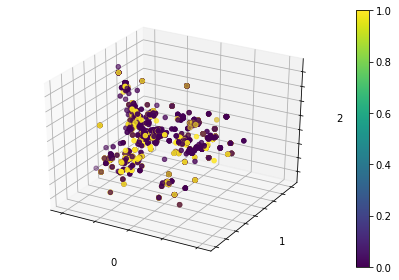

In [23]:
d = d.detach().numpy()
labels = targets_train.reset_index()
labels.index = [str(i) for i in labels.index]
plot = skbio.stats.ordination.pcoa(d)
print(plot.proportion_explained[['PC1', 'PC2', 'PC3']])
plot = plot.plot(df = labels, column = 'target_Energetic', cmap = 'viridis')


The plot above illustrates quite well why RBF struggles to serve as a foundation for highly precise models in predicting 'Energetic' cannabis strains. The light colored dots represent Energetic cannabis strains, while dark colored dots indicate non-Energetic strains. In this three dimensional view, one can identify 4 main clusters of points (one large, two medium flanking the large, and one small slightly further away). Light and dark colored dots are distributed throughout all four clusters, with no evident higher density areas of light colored dots separate from dark colored dots. Viewing this in three dimensions is undoubtedly a simplification, as these three dimensions only account for about 20% of the variance in the dataset. However, they do suggest that given this kernel and this feature space, Energetic and non Energetic cannabis strains are poorly separable.

We see very similar outputs for our two custom kernels:

In [24]:
pyro.clear_param_store()
kernel = KA(input_dim = 48, 
            variance = torch.tensor(1.),
            alpha = torch.tensor(0.533), # using the learned alpha
           marginal_probs = torch.tensor(np.array(marginal_probs)))
cov = kernel(torch.Tensor(np.array(feats_train)))
d = (1 - cov)
d[d < 1e-15] = 0
d

tensor([[0.0000, 0.8831, 0.5012,  ..., 0.7086, 0.7648, 0.7991],
        [0.8831, 0.0000, 0.8913,  ..., 0.8757, 0.8884, 0.8911],
        [0.5012, 0.8913, 0.0000,  ..., 0.7505, 0.7929, 0.8222],
        ...,
        [0.7086, 0.8757, 0.7505,  ..., 0.0000, 0.7364, 0.7760],
        [0.7648, 0.8884, 0.7929,  ..., 0.7364, 0.0000, 0.5098],
        [0.7991, 0.8911, 0.8222,  ..., 0.7760, 0.5098, 0.0000]],
       dtype=torch.float64, grad_fn=<IndexPutBackward>)

PC1    0.076732
PC2    0.068948
PC3    0.065678
dtype: float64


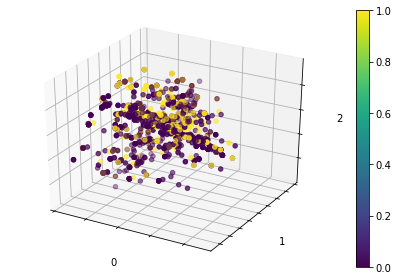

In [25]:
d = d.detach().numpy()
labels = targets_train.reset_index()
labels.index = [str(i) for i in labels.index]
plot = skbio.stats.ordination.pcoa(d)
print(plot.proportion_explained[['PC1', 'PC2', 'PC3']])
plot = plot.plot(df=labels, column='target_Energetic', cmap = 'viridis')

In [26]:
pyro.clear_param_store()
kernel = KABG(input_dim = 48, 
              variance = torch.tensor(1.),
              alpha = torch.tensor(1.672), # learned values for alpha, beta, and gamma
              beta = torch.tensor(0.38),
              gamma = torch.tensor(2.308),
              marginal_probs = torch.tensor(np.array(marginal_probs)))
cov = kernel(torch.Tensor(np.array(feats_train)))
d = (1 - cov)
d[d < 1e-15] = 0
d = (d * 10**10).round() / (10**10)
d

tensor([[0.0000, 0.9712, 0.5563,  ..., 0.8263, 0.8387, 0.9705],
        [0.9712, 0.0000, 0.9713,  ..., 0.9696, 0.9714, 0.9725],
        [0.5563, 0.9713, 0.0000,  ..., 0.8272, 0.8395, 0.9707],
        ...,
        [0.8263, 0.9696, 0.8272,  ..., 0.0000, 0.8273, 0.9689],
        [0.8387, 0.9714, 0.8395,  ..., 0.8273, 0.0000, 0.7803],
        [0.9705, 0.9725, 0.9707,  ..., 0.9689, 0.7803, 0.0000]],
       dtype=torch.float64, grad_fn=<DivBackward0>)

PC1    0.111582
PC2    0.093562
PC3    0.076967
dtype: float64


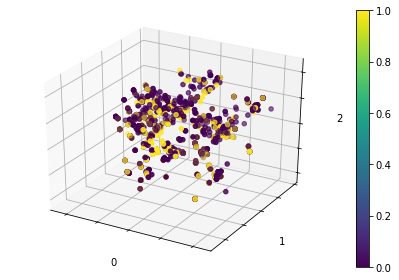

In [27]:
d = d.detach().numpy()
labels = targets_train.reset_index()
labels.index = [str(i) for i in labels.index]
plot = skbio.stats.ordination.pcoa(d)
print(plot.proportion_explained[['PC1', 'PC2', 'PC3']])
plot = plot.plot(df=labels, column='target_Energetic', cmap = 'viridis')

In all three cases, when visualized in three dimensions, we do not see any major separation between Energetic and non-Energetic strains. This could suggest two things: that the kernels are not working (as well) as we would expect OR that our feature set is insufficient for precisely predicting Energetic cannabis strains.

Let's create the same visualizations as we did above, but instead look at how a feature, having the aroma of berries for example, is distributed in the three dimensional space.

First, RBF

In [44]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim = 48, variance = torch.tensor(1),
                        lengthscale = torch.tensor(0.919)) # using the learned lengthscale
cov = kernel(torch.Tensor(np.array(feats_train)))
cov[cov < 1e-15] = 0
d = (1 - cov)
d[d < 1e-15] = 0
d

tensor([[0.0000, 0.9713, 0.6940,  ..., 0.9063, 0.9063, 0.9713],
        [0.9713, 0.0000, 0.9713,  ..., 0.9713, 0.9713, 0.9713],
        [0.6940, 0.9713, 0.0000,  ..., 0.9063, 0.9063, 0.9713],
        ...,
        [0.9063, 0.9713, 0.9063,  ..., 0.0000, 0.9063, 0.9713],
        [0.9063, 0.9713, 0.9063,  ..., 0.9063, 0.0000, 0.9063],
        [0.9713, 0.9713, 0.9713,  ..., 0.9713, 0.9063, 0.0000]],
       grad_fn=<IndexPutBackward>)

PC1    0.076963
PC2    0.071058
PC3    0.056063
dtype: float64


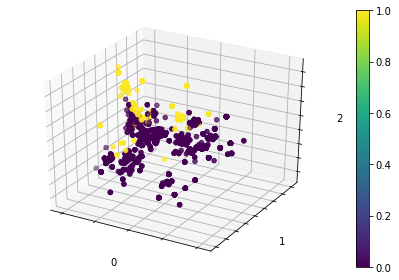

In [45]:
d = d.detach().numpy()
labels = feats_train.reset_index()
labels.index = [str(i) for i in labels.index]
plot = skbio.stats.ordination.pcoa(d)
print(plot.proportion_explained[['PC1', 'PC2', 'PC3']])
plot = plot.plot(df=labels, column='feature_Berry')

Then KA

In [46]:
pyro.clear_param_store()
kernel = KA(input_dim = 48, 
            variance = torch.tensor(1.),
            alpha = torch.tensor(0.533), # using the learned alpha
           marginal_probs = torch.tensor(np.array(marginal_probs)))
cov = kernel(torch.Tensor(np.array(feats_train)))
d = (1 - cov)
d[d < 1e-15] = 0
d

tensor([[0.0000, 0.8831, 0.5012,  ..., 0.7086, 0.7648, 0.7991],
        [0.8831, 0.0000, 0.8913,  ..., 0.8757, 0.8884, 0.8911],
        [0.5012, 0.8913, 0.0000,  ..., 0.7505, 0.7929, 0.8222],
        ...,
        [0.7086, 0.8757, 0.7505,  ..., 0.0000, 0.7364, 0.7760],
        [0.7648, 0.8884, 0.7929,  ..., 0.7364, 0.0000, 0.5098],
        [0.7991, 0.8911, 0.8222,  ..., 0.7760, 0.5098, 0.0000]],
       dtype=torch.float64, grad_fn=<IndexPutBackward>)

PC1    0.076732
PC2    0.068948
PC3    0.065678
dtype: float64


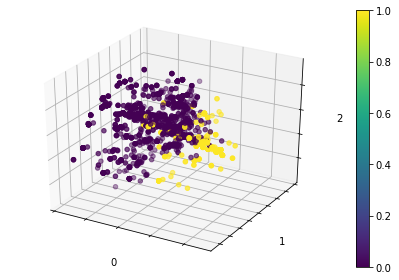

In [47]:
d = d.detach().numpy()
labels = feats_train.reset_index()
labels.index = [str(i) for i in labels.index]
plot = skbio.stats.ordination.pcoa(d)
print(plot.proportion_explained[['PC1', 'PC2', 'PC3']])
plot = plot.plot(df=labels, column='feature_Berry')

And finally, KABG

In [48]:
pyro.clear_param_store()
kernel = KABG(input_dim = 48, 
              variance = torch.tensor(1.),
              alpha = torch.tensor(1.672), # learned values for alpha, beta, and gamma
              beta = torch.tensor(0.38),
              gamma = torch.tensor(2.308),
              marginal_probs = torch.tensor(np.array(marginal_probs)))
cov = kernel(torch.Tensor(np.array(feats_train)))
d = (1 - cov)
d[d < 1e-15] = 0
d = (d * 10**10).round() / (10**10)
d

tensor([[0.0000, 0.9712, 0.5563,  ..., 0.8263, 0.8387, 0.9705],
        [0.9712, 0.0000, 0.9713,  ..., 0.9696, 0.9714, 0.9725],
        [0.5563, 0.9713, 0.0000,  ..., 0.8272, 0.8395, 0.9707],
        ...,
        [0.8263, 0.9696, 0.8272,  ..., 0.0000, 0.8273, 0.9689],
        [0.8387, 0.9714, 0.8395,  ..., 0.8273, 0.0000, 0.7803],
        [0.9705, 0.9725, 0.9707,  ..., 0.9689, 0.7803, 0.0000]],
       dtype=torch.float64, grad_fn=<DivBackward0>)

PC1    0.111582
PC2    0.093562
PC3    0.076967
dtype: float64


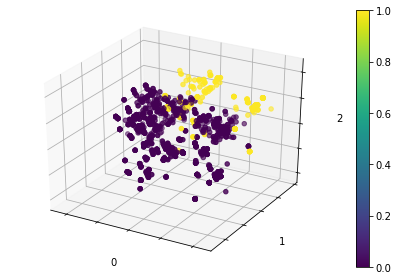

In [49]:
d = d.detach().numpy()
labels = feats_train.reset_index()
labels.index = [str(i) for i in labels.index]
plot = skbio.stats.ordination.pcoa(d)
print(plot.proportion_explained[['PC1', 'PC2', 'PC3']])
plot = plot.plot(df=labels, column='feature_Berry')

As we can see in all three cases, our kernels do indeed seem to be working how we expect them to work - samples with similar flavor profiles (e.g. taste like Berry) are clustered together and can even show some degree of separation from the other samples! 

#### Conclusions
So, where does this leave us? Well, we now have a couple of more thoughtful and intuitive kernel options when approaching problems with a feature space made up of binary variables. And based on our visualizations above, our new kernels do behave as we would expect them to behave, in terms of assigning a larger covariance (visualized as being plotted a smaller distance apart) to samples with features in common. In fact, RBF seems to do a decent job in this regard as well, although we also were able to illustrate some less than optimal behaviors in how RBF determines covariance (e.g. some sample pairs having no features in common having higher covariance than sample pairs with features in common).

Even with more appropriate kernels, we struggled to learn precise classifiers of Energetic cannabis strains. However, by visualizing how target labels and feature labels are distributed in three dimensional space, we were able to reveal the disconnect between how covariance operates in our current feature space and how our target label maps to that covariance.

In the end, we come to the same conclusion as we came to before: that what we are truly facing is a feature engineering problem. In the next iteration of our journey towards developing precise models for predicting Energetic cannabis strains, we will experiment with features crosses ('ands') and feature bins ('ors'), custom features via conceptual binning, and strategies for regularizing and subsetting our evalanche of new features.

**Resources**:
- [Pyro Gaussian Process Tutorial](https://pyro.ai/examples/gp.html)
- [Fantastic slide deck discussing Gaussian Processes](https://www.robots.ox.ac.uk/seminars/Extra/2012_30_08_MichaelOsborne.pdf)
- [Deep Kernal Classifier implemented with Pyro](https://github.com/pyro-ppl/pyro/blob/dev/examples/contrib/gp/sv-dkl.py) 
- [Interesting Informatics Engineering Thesis titled "Multivariate Kernel Functions for
Categorical Variables"](https://upcommons.upc.edu/bitstream/handle/2099.1/24508/99930.pdf?sequence=1)
- [Textbook titled "Pattern Analysis" by Prof. Michael I. Jordan](https://people.eecs.berkeley.edu/~jordan/kernels/0521813972c03_p47-84.pdf)

Note: Turns out, great minds think alike! (; the first kernel I implement above is very similar to one featured in Ch 4 of the thesis mentioned above. The kernel is referred to therein as s7.

